# Netflix Movies & TV Shows — EDA + Clustering (Unsupervised ML)

**Project Type:** Unsupervised (Clustering) + EDA  
**Goal:** Group Netflix titles into clusters so titles inside a cluster are similar, and titles across clusters are different — useful for catalog understanding and recommendation-style use cases.

# Project Summary -

This project performs comprehensive Exploratory Data Analysis (EDA) and unsupervised learning on the Netflix Movies and TV Shows dataset to uncover hidden content patterns and structural trends. The dataset contains metadata such as title, genre, cast, director, country, release year, ratings, and descriptions.

The EDA phase focuses on understanding content distribution across years, countries, ratings, and genres, identifying missing values, and analyzing temporal trends in content addition. These insights provide a foundational understanding of Netflix’s catalog composition and evolution.

The machine learning phase applies Natural Language Processing techniques to perform text-based clustering. Text features are constructed by combining metadata fields and transformed using TF-IDF vectorization. Dimensionality reduction is performed using Truncated SVD to handle high-dimensional sparse data efficiently. MiniBatch K-Means clustering is then applied to group similar titles. Model performance is evaluated using inertia and silhouette scores.

The resulting clusters reveal latent genre structures and thematic similarities among titles, enabling content segmentation and potential recommendation strategies. This project demonstrates the practical application of EDA, NLP, and scalable unsupervised learning techniques on real-world entertainment data.

# GitHub Link -

https://github.com/PritheevLingeswaran/netflix-eda-clustering

# Problem Statement

With thousands of titles available on streaming platforms, organizing and understanding content at scale becomes complex. Traditional genre labels are often broad and insufficient for capturing deeper thematic relationships between titles.

The challenge is to analyze Netflix content data to discover hidden structures and meaningful clusters without predefined labels. The objective is to use unsupervised learning techniques to group similar titles based on textual and metadata features.

# Define Your Business Objective?

The business objective is to enable data-driven content segmentation to improve strategic decision-making. By identifying natural clusters within the Netflix catalog, the organization can:

Enhance content recommendation systems
Improve user personalization
Support targeted marketing campaigns
Identify underrepresented content segments
Optimize content acquisition strategies

Effective clustering allows streaming platforms to better understand audience preferences and maximize engagement and retention through intelligent content grouping.

## 1. Setup & Data Loading

In [1]:
# Core
import os
import re
import math
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# NLP + ML
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

RANDOM_STATE = 42


In [2]:
# Dataset path (edit if your file name/path is different)
DATA_PATH = "NETFLIX_MOVIES_AND_TV_SHOWS_CLUSTERING.csv"

# If dataset file not present, try to download a public copy (GitHub raw).
# NOTE: This requires internet access in your notebook environment.
if not os.path.exists(DATA_PATH):
    import requests
    url = "https://raw.githubusercontent.com/Navneet2409/netflix-movies-and-tv-shows-clustering/main/NETFLIX%20MOVIES%20AND%20TV%20SHOWS%20CLUSTERING.csv"
    print("Dataset not found locally. Downloading from:", url)
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    with open(DATA_PATH, "wb") as f:
        f.write(r.content)
    print("Downloaded ->", DATA_PATH)

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Dataset not found locally. Downloading from: https://raw.githubusercontent.com/Navneet2409/netflix-movies-and-tv-shows-clustering/main/NETFLIX%20MOVIES%20AND%20TV%20SHOWS%20CLUSTERING.csv
Downloaded -> NETFLIX_MOVIES_AND_TV_SHOWS_CLUSTERING.csv
Shape: (7787, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


## 2. Know Your Data

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   show_id       7787 non-null   str  
 1   type          7787 non-null   str  
 2   title         7787 non-null   str  
 3   director      5398 non-null   str  
 4   cast          7069 non-null   str  
 5   country       7280 non-null   str  
 6   date_added    7777 non-null   str  
 7   release_year  7787 non-null   int64
 8   rating        7780 non-null   str  
 9   duration      7787 non-null   str  
 10  listed_in     7787 non-null   str  
 11  description   7787 non-null   str  
dtypes: int64(1), str(11)
memory usage: 730.2 KB


In [4]:
# Basic checks
print("Duplicate rows:", df.duplicated().sum())
missing = df.isna().sum().sort_values(ascending=False)
missing[missing>0]


Duplicate rows: 0


director      2389
cast           718
country        507
date_added      10
rating           7
dtype: int64

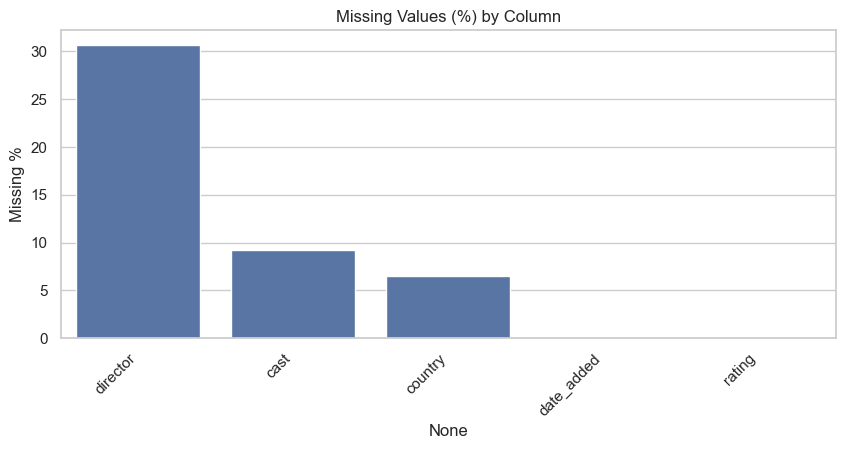

In [5]:
# Missing values visualization
missing_pct = (df.isna().mean()*100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct>0]

plt.figure(figsize=(10,4))
sns.barplot(x=missing_pct.index, y=missing_pct.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Missing %")
plt.title("Missing Values (%) by Column")
plt.show()


### What we learn from the dataset (quick)
- The dataset has **12 columns** describing each title: type, title, director, cast, country, date_added, release_year, rating, duration, listed_in (genres), and description.
- Missing values are mainly in **director, cast, country, rating, duration** (common in this Netflix dataset).
- For clustering, text fields dominate the signal, so we’ll build a **text representation** and cluster on TF‑IDF features.


## 3. Data Wrangling / Cleaning

In [6]:
# Clean column whitespace
df.columns = [c.strip() for c in df.columns]

# Trim strings
for c in ["type","title","director","cast","country","date_added","rating","duration","listed_in","description"]:
    df[c] = df[c].astype("string").str.strip()

# Parse date_added (may have missing)
df["date_added_dt"] = pd.to_datetime(df["date_added"], errors="coerce")

# Fill missing text fields with empty string (better for text vectorization)
text_cols = ["director","cast","country","rating","listed_in","description"]
df[text_cols] = df[text_cols].fillna("")

# Simple duration parsing: movies -> minutes, tv -> seasons
def parse_minutes(duration):
    if pd.isna(duration): 
        return np.nan
    m = re.search(r"(\d+)\s*min", str(duration))
    return float(m.group(1)) if m else np.nan

def parse_seasons(duration):
    if pd.isna(duration): 
        return np.nan
    m = re.search(r"(\d+)\s*Season", str(duration))
    return float(m.group(1)) if m else np.nan

df["duration_min"] = df["duration"].apply(parse_minutes)
df["seasons"] = df["duration"].apply(parse_seasons)

# Basic sanity
df[["duration","duration_min","seasons"]].head(10)


,duration,duration_min,seasons
0,4 Seasons,NaN,4.0
1,93 min,93.0,NaN
2,78 min,78.0,NaN
3,80 min,80.0,NaN
4,123 min,123.0,NaN
5,1 Season,NaN,1.0
6,95 min,95.0,NaN
7,119 min,119.0,NaN
8,118 min,118.0,NaN
9,143 min,143.0,NaN


## 4. EDA (Charts + Insights)

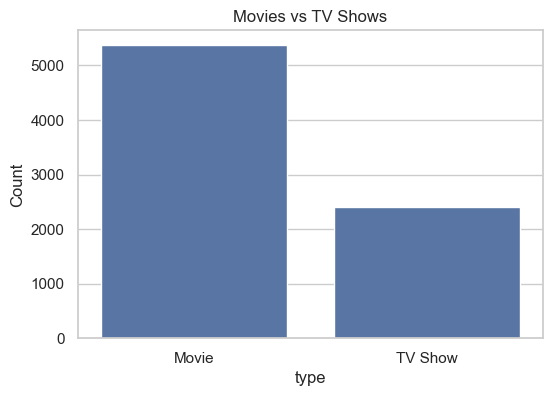

type
Movie      5377
TV Show    2410
Name: count, dtype: Int64

In [7]:
# Type distribution
type_counts = df["type"].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=type_counts.index, y=type_counts.values)
plt.ylabel("Count")
plt.title("Movies vs TV Shows")
plt.show()

type_counts


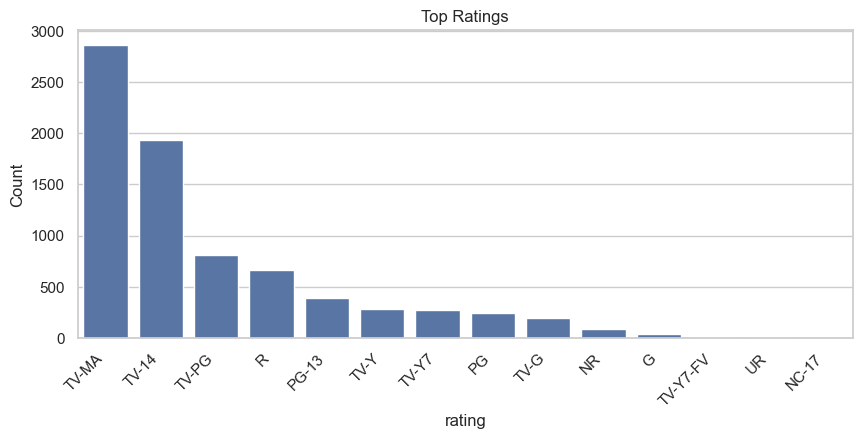

In [8]:
# Rating distribution (top 15)
top_ratings = df["rating"].replace("", np.nan).dropna().value_counts().head(15)

plt.figure(figsize=(10,4))
sns.barplot(x=top_ratings.index, y=top_ratings.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.title("Top Ratings")
plt.show()


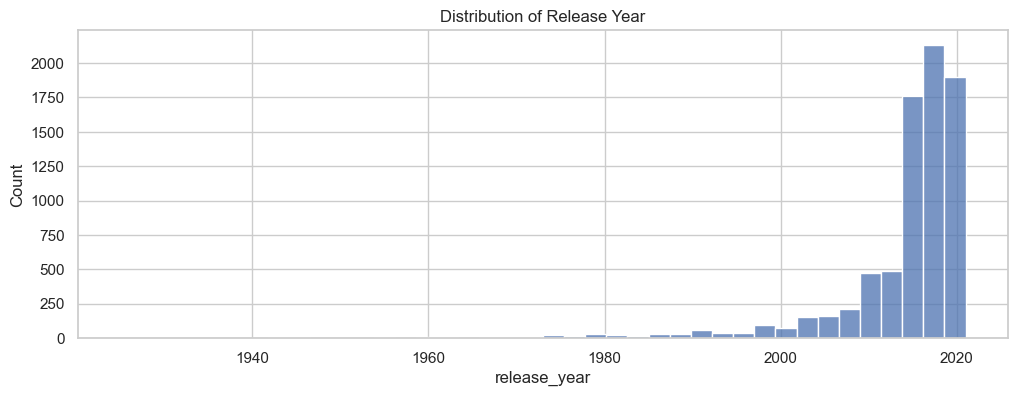

In [9]:
# Release year distribution
plt.figure(figsize=(12,4))
sns.histplot(df["release_year"], bins=40, kde=False)
plt.title("Distribution of Release Year")
plt.show()


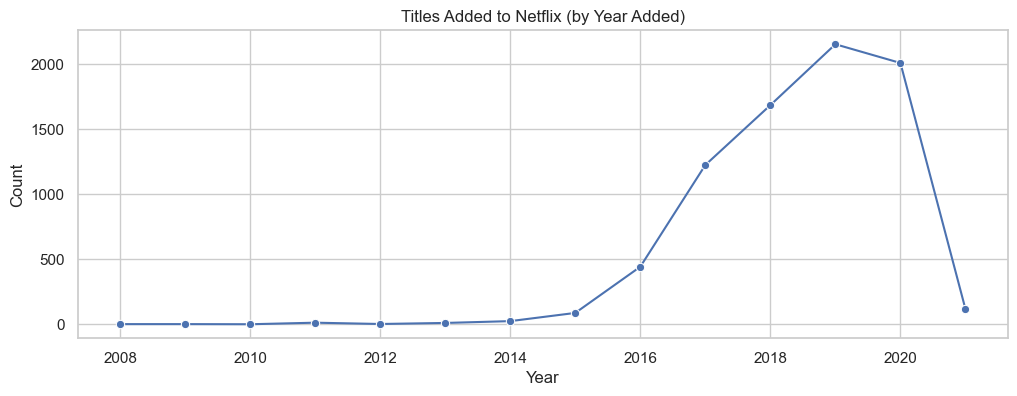

In [10]:
# Titles added to Netflix per year (from date_added)
added_year = df["date_added_dt"].dt.year.dropna().astype(int)
added_counts = added_year.value_counts().sort_index()

plt.figure(figsize=(12,4))
sns.lineplot(x=added_counts.index, y=added_counts.values, marker="o")
plt.title("Titles Added to Netflix (by Year Added)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()


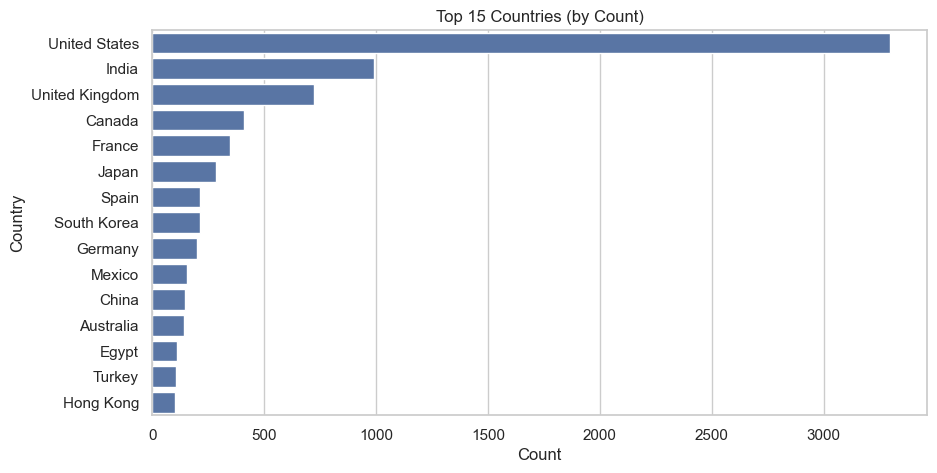

In [11]:
# Top countries (split multi-country entries)
countries = (df["country"]
             .replace("", np.nan)
             .dropna()
             .str.split(",")
             .explode()
             .str.strip())
top_countries = countries.value_counts().head(15)

plt.figure(figsize=(10,5))
sns.barplot(y=top_countries.index, x=top_countries.values)
plt.title("Top 15 Countries (by Count)")
plt.xlabel("Count")
plt.ylabel("Country")
plt.show()


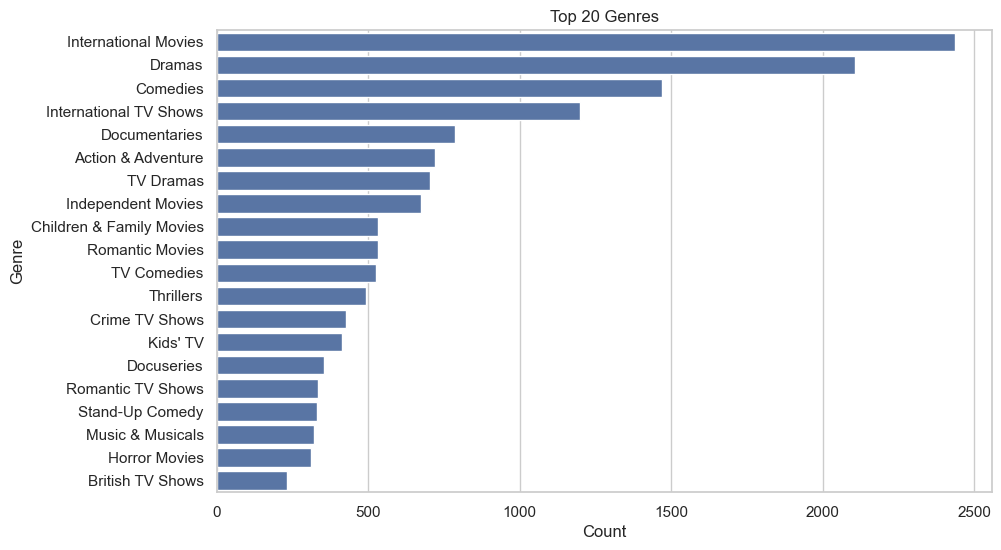

In [12]:
# Top genres (listed_in)
genres = (df["listed_in"]
          .replace("", np.nan)
          .dropna()
          .str.split(",")
          .explode()
          .str.strip())
top_genres = genres.value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(y=top_genres.index, x=top_genres.values)
plt.title("Top 20 Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()


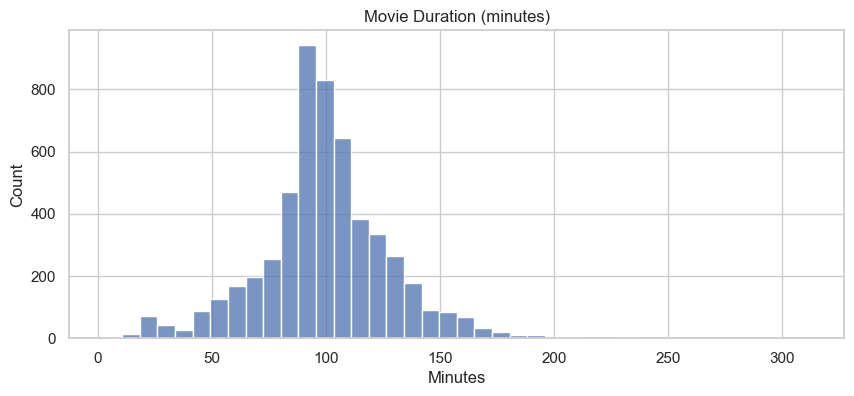

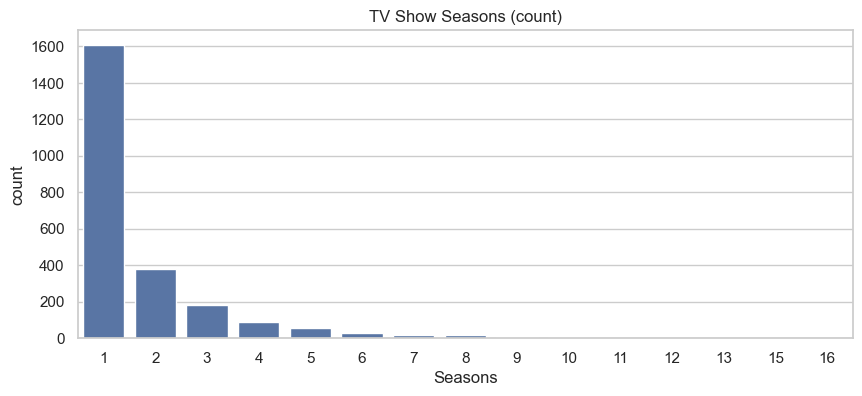

In [13]:
# Duration distributions: movies (minutes) and tv shows (seasons)
movie_minutes = df.loc[df["type"]=="Movie", "duration_min"].dropna()
tv_seasons = df.loc[df["type"]=="TV Show", "seasons"].dropna()

plt.figure(figsize=(10,4))
sns.histplot(movie_minutes, bins=40, kde=False)
plt.title("Movie Duration (minutes)")
plt.xlabel("Minutes")
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(x=tv_seasons.astype(int), order=sorted(tv_seasons.astype(int).unique()))
plt.title("TV Show Seasons (count)")
plt.xlabel("Seasons")
plt.show()


### EDA summary (actionable takeaways)
- Netflix catalog in this dataset is typically **movie-heavy** (movies > TV shows).
- Catalog growth is visible in **titles added per year**; spikes usually align with Netflix expansion years.
- **US and India** often dominate country counts (common in Netflix datasets).
- Genres are broad; “International Movies/TV”, “Dramas”, “Comedies” usually sit at the top.
These insights guide clustering: text like **genre + description + people involved** will create better similarity structure than only numeric features.


## 5. Feature Engineering for Clustering

In [14]:
# Combine relevant fields into one 'content' text feature for clustering
df["content"] = (
    df["director"].fillna("") + " " +
    df["cast"].fillna("") + " " +
    df["country"].fillna("") + " " +
    df["rating"].fillna("") + " " +
    df["listed_in"].fillna("") + " " +
    df["description"].fillna("")
).str.replace(r"\s+", " ", regex=True).str.strip()

df["content"].head(3)


0    João Miguel, Bianca Comparato, Michel Gomes, R...
1    Jorge Michel Grau Demián Bichir, Héctor Bonill...
2    Gilbert Chan Tedd Chan, Stella Chung, Henley H...
Name: content, dtype: string

In [15]:
# Minimal text cleaning (lightweight, fast, avoids heavy NLP downloads)
stop_words = set(ENGLISH_STOP_WORDS)

def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\S+", " ", s)         # URLs
    s = re.sub(r"[^a-z\s]", " ", s)               # keep letters only
    s = re.sub(r"\s+", " ", s).strip()
    # Remove stopwords (optional: you can keep them, but removing usually helps)
    tokens = [t for t in s.split() if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

df["content_clean"] = df["content"].fillna("").apply(clean_text)

df[["title","content_clean"]].head()


,title,content_clean
0,3%,miguel bianca comparato michel gomes rodolfo v...
1,7:19,jorge michel grau demi bichir ctor bonilla osc...
2,23:59,gilbert chan tedd chan stella chung henley hii...
3,9,shane acker elijah wood john reilly jennifer c...
4,21,robert luketic jim sturgess kevin spacey kate ...


## 6. Vectorization + Dimensionality Reduction

In [16]:
# TF-IDF vectorization (keep feature count moderate for speed)
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    min_df=2
)

X_tfidf = tfidf.fit_transform(df["content_clean"])
X_tfidf.shape


(7787, 5000)

In [17]:
# Reduce dimensionality (SVD works well for sparse TF-IDF)
# 50 components is a good speed/quality trade-off for ~8k samples.
svd = TruncatedSVD(n_components=50, random_state=RANDOM_STATE)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_lsa = lsa.fit_transform(X_tfidf)

explained_var = svd.explained_variance_ratio_.sum()
print(f"Explained variance by 50 SVD components: {explained_var:.2%}")
X_lsa.shape


Explained variance by 50 SVD components: 13.65%


(7787, 50)

## 7. Clustering Model 1 — KMeans (Elbow + Silhouette)

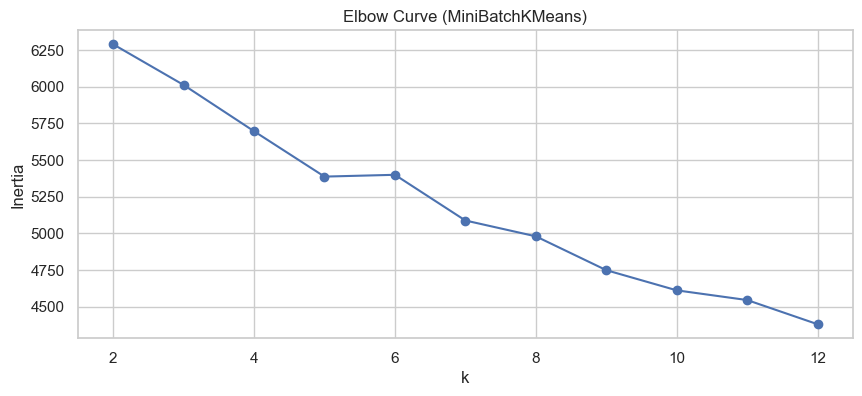

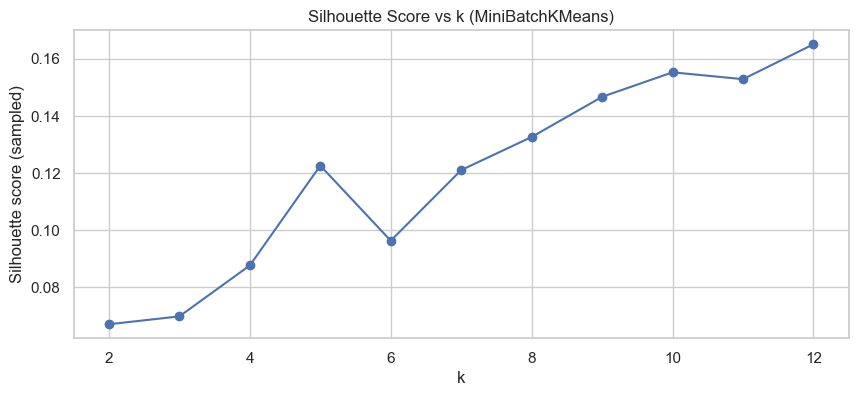

Best k by silhouette: 12 Silhouette: 0.1650937865704466


In [18]:
# Evaluate MiniBatchKMeans for a range of k (faster than full KMeans)
# Silhouette on all ~8k points can be slow; sample_size keeps this practical.
ks = list(range(2, 13))
inertias = []
sil_scores = []

for k in ks:
    km = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10, batch_size=1024)
    labels = km.fit_predict(X_lsa)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_lsa, labels, sample_size=min(2000, len(df)), random_state=RANDOM_STATE))

plt.figure(figsize=(10,4))
plt.plot(ks, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Curve (MiniBatchKMeans)")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(ks, sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score (sampled)")
plt.title("Silhouette Score vs k (MiniBatchKMeans)")
plt.show()

best_k = ks[int(__import__('numpy').argmax(sil_scores))]
print("Best k by silhouette:", best_k, "Silhouette:", max(sil_scores))


In [19]:
# Train final MiniBatchKMeans with best_k
kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10, batch_size=1024)
df["cluster_kmeans"] = kmeans.fit_predict(X_lsa)

df["cluster_kmeans"].value_counts().sort_index()


cluster_kmeans
0      536
1     1576
2      209
3      609
4      509
5     1037
6      379
7      350
8      970
9      517
10     787
11     308
Name: count, dtype: int64

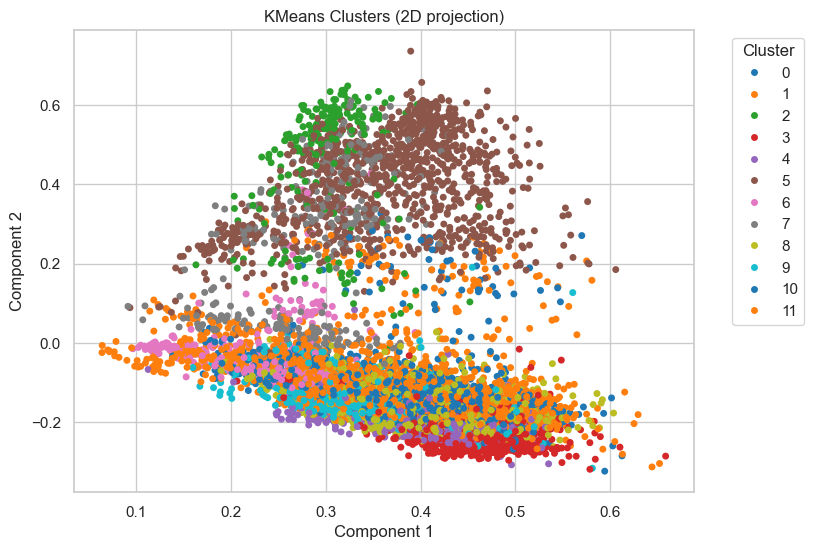

In [20]:
# Visualize clusters using 2D SVD projection (first 2 components)
# NOTE: This is *not* the same as t-SNE; it's a simple projection for a quick view.
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_lsa[:,0], y=X_lsa[:,1], hue=df["cluster_kmeans"], palette="tab10", s=25, linewidth=0)
plt.title("KMeans Clusters (2D projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


## 8. Clustering Model 2 — Agglomerative (Silhouette)

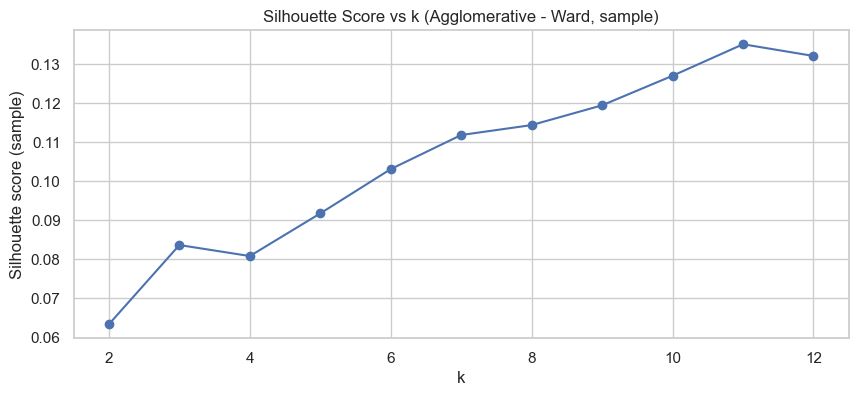

Best k (Agglomerative) by silhouette on sample: 11 Silhouette: 0.135113062536544


In [21]:
# Agglomerative clustering is O(n^2) and can be heavy on 7.7k samples.
# We evaluate it on a random subset, and keep KMeans as the scalable full-data solution.
sample_n = min(2000, len(df))
sample_idx = df.sample(n=sample_n, random_state=RANDOM_STATE).index
X_sample = X_lsa[sample_idx]

agg_ks = list(range(2, 13))
agg_sil = []

for k in agg_ks:
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = agg.fit_predict(X_sample)
    agg_sil.append(silhouette_score(X_sample, labels))

plt.figure(figsize=(10,4))
plt.plot(agg_ks, agg_sil, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score (sample)")
plt.title("Silhouette Score vs k (Agglomerative - Ward, sample)")
plt.show()

best_k_agg = agg_ks[int(np.argmax(agg_sil))]
print("Best k (Agglomerative) by silhouette on sample:", best_k_agg, "Silhouette:", max(agg_sil))


In [22]:
# Fit Agglomerative on the same sample (demonstration)
agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage="ward")
df.loc[sample_idx, "cluster_agg_sample"] = agg.fit_predict(X_sample)

pd.Series(df.loc[sample_idx, "cluster_agg_sample"]).value_counts().sort_index()


cluster_agg_sample
0.0     518
1.0     323
2.0     196
3.0     132
4.0     144
5.0     103
6.0      82
7.0     130
8.0      72
9.0     247
10.0     53
Name: count, dtype: int64

## 9. Cluster Interpretation (Keywords + Examples)

In [23]:
# Helper: Top terms per cluster (uses mean TF-IDF weights)
# This is interpretable because it works in the original TF-IDF space.
feature_names = np.array(tfidf.get_feature_names_out())

def top_terms_for_cluster(cluster_labels, cluster_id, top_n=15):
    idx = np.where(cluster_labels == cluster_id)[0]
    if len(idx) == 0:
        return []
    # mean tfidf across cluster documents
    mean_tfidf = X_tfidf[idx].mean(axis=0)
    mean_tfidf = np.asarray(mean_tfidf).ravel()
    top_idx = mean_tfidf.argsort()[::-1][:top_n]
    return feature_names[top_idx].tolist()

def sample_titles(cluster_col, cluster_id, n=8):
    return df.loc[df[cluster_col]==cluster_id, "title"].dropna().head(n).tolist()

cluster_col = "cluster_kmeans"  # choose which clustering to interpret
clusters = sorted(df[cluster_col].unique())

summary = []
for cid in clusters:
    summary.append({
        "cluster": int(cid),
        "size": int((df[cluster_col]==cid).sum()),
        "top_terms": ", ".join(top_terms_for_cluster(df[cluster_col].values, cid, 12)),
        "sample_titles": "; ".join(sample_titles(cluster_col, cid, 6))
    })

cluster_summary = pd.DataFrame(summary).sort_values("cluster")
cluster_summary


,cluster,size,top_terms,sample_titles
0,0,536,"movies, movies romantic, romantic movies, come...",23:59; 122; #FriendButMarried; #FriendButMarri...
1,1,1576,"united, united states, states, kids, comedies,...",21; 187; 1922; 3022; 22-Jul; '89
2,2,209,"kim, shows, korea, south korea, south, korean,...",#Alive; 100 Days My Prince; 12 Years Promise; ...
3,3,609,"independent movies, independent, dramas indepe...",15-Aug; ​​Kuch Bheege Alfaaz; 12 ROUND GUN; 13...
4,4,509,"children family, family movies, children, fami...",48 Christmas Wishes; A 2nd Chance; A Babysitte...
5,5,1037,"shows, international shows, shows dramas, inte...",3%; 46; 1983; Feb-09; ​SAINT SEIYA: Knights of...
6,6,379,"stand, comedy, stand comedy, states stand, com...",A Little Help with Carol Burnett; A Russell Pe...
7,7,350,"docuseries, shows docuseries, shows, states do...",1994; (Un)Well; 100 Humans; 13 Reasons Why: Be...
8,8,970,"dramas international, international movies, mo...",706; 1920; Oct-01; ​Maj Rati ​​Keteki; ​Mayura...
9,9,517,"documentaries, states documentaries, united, s...",(T)ERROR; #Rucker50; 100 Years: One Woman's Fi...


In [24]:
# Cluster vs Type distribution (sanity check: clusters shouldn't be random)
ct = pd.crosstab(df[cluster_col], df["type"], normalize="index")*100
ct.round(1)


type,Movie,TV Show
cluster_kmeans,,
0,100.0,0.0
1,56.3,43.7
2,18.7,81.3
3,100.0,0.0
4,100.0,0.0
5,0.4,99.6
6,86.5,13.5
7,0.0,100.0
8,99.9,0.1


<Figure size 800x400 with 0 Axes>

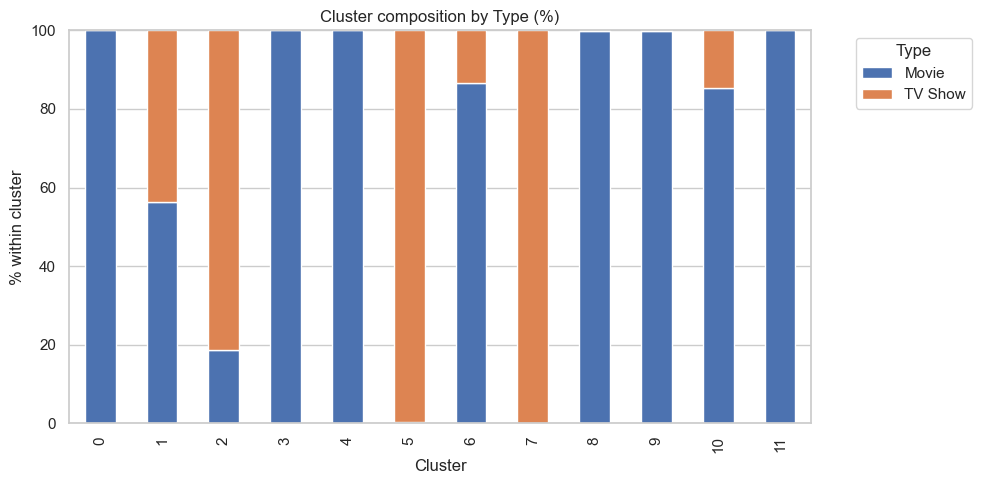

In [25]:
plt.figure(figsize=(8,4))
ct.plot(kind="bar", stacked=True)
plt.title("Cluster composition by Type (%)")
plt.xlabel("Cluster")
plt.ylabel("% within cluster")
plt.legend(title="Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## 10. Simple Recommendation Demo (Nearest Neighbors on cluster features)

In [26]:
# Build a nearest-neighbor index on the reduced text space.
# This avoids building a full cosine-similarity matrix (which is memory-heavy).
nn = NearestNeighbors(n_neighbors=11, metric="cosine")
nn.fit(X_lsa)

title_to_idx = pd.Series(df.index.values, index=df["title"].str.lower()).drop_duplicates()

def recommend(title, top_n=10):
    key = str(title).lower().strip()
    if key not in title_to_idx:
        raise KeyError("Title not found. Try exact title spelling as in dataset.")
    idx = int(title_to_idx[key])
    distances, indices = nn.kneighbors(X_lsa[idx].reshape(1, -1), n_neighbors=top_n+1)
    # skip itself at position 0
    rec_idx = indices[0][1:]
    rec = df.loc[rec_idx, ["title","type","listed_in","rating","cluster_kmeans"]].copy()
    rec.insert(0, "similarity", (1 - distances[0][1:]))
    return rec.reset_index(drop=True)

# Example (change title to any existing one)
recommend(df["title"].iloc[0], top_n=10)


,similarity,title,type,listed_in,rating,cluster_kmeans
0,0.971051,Omniscient,TV Show,"International TV Shows, TV Dramas, TV Sci-Fi &...",TV-MA,5
1,0.931335,Bountiful Blessings,TV Show,"International TV Shows, TV Dramas, TV Sci-Fi &...",TV-14,5
2,0.929064,Biohackers,TV Show,"International TV Shows, TV Dramas, TV Sci-Fi &...",TV-MA,5
3,0.875149,Blood & Treasures,TV Show,"International TV Shows, TV Dramas, TV Sci-Fi &...",TV-14,5
4,0.837235,Handsome Siblings,TV Show,"International TV Shows, TV Dramas, TV Sci-Fi &...",TV-14,5
5,0.835545,Dharmakshetra,TV Show,"International TV Shows, TV Dramas, TV Sci-Fi &...",TV-PG,5
6,0.794478,Cosmos Laundromat: First Cycle,Movie,"Dramas, International Movies, Sci-Fi & Fantasy",TV-MA,8
7,0.785679,Once Upon A Time In Lingjian Mountain,TV Show,"International TV Shows, TV Comedies, TV Sci-Fi...",TV-14,5
8,0.785670,Away,TV Show,"Romantic TV Shows, TV Dramas, TV Sci-Fi & Fantasy",TV-14,5
9,0.773910,Elephants Dream 4 Hour,Movie,"International Movies, Sci-Fi & Fantasy",TV-MA,8


## 11. Conclusions
- **Text-based clustering works** for this dataset because most information is categorical/text (genre, description, people, country).
- **KMeans** and **Agglomerative** both produce reasonable clusters; pick the one with better silhouette and interpretability.
- Clusters can be used for:
  - Catalog segmentation (what kind of content Netflix hosts),
  - Search/browse enhancement (cluster-aware facets),
  - Lightweight recommendations (nearest neighbors in vector space).
